# Portfolio Construction & Optimization


### Introduction and Display Data

Our strategy is to invest in a combination of low-risk assets, such as government bonds, and high-risk assets, such as technology stocks. The goal of this strategy is to balance the potential for higher returns from the high-risk assets with the stability provided by the low-risk assets.

To implement this strategy, we chose 4 technology stocks based on Nasdaq 100 and S&P 500, respectively APPL(APPLE INC.), AMZN(AMAZON COM INC.), GOOGL(ALPHABET INC.) and TSLA (TESLA MOTORS INC.) as our high-risk(and possibly high returns) assets. We then selected 10 Year Treasury Bond ETF (TLH) as our risk-free asset.

To assess the historical performance of this strategy, the investor would need to have access to data on the performance of both government bonds and technology stocks. We obtained these stock data from WRDS's CRSP database, as shown in the stockdata.csv file. The data includes 10 years' monthly stock prices and simple monthly returns from 2012/01 to 2021/12, as well as other historical information like vwretd and ewretd for our reference. We choosed monthly data instead of daily data for the concern of stability. Moreover, we decided to collect the historical data of the stocks for the past 10 year so that we could assess their long-term performance and avoid some occasional events.

We built a static portfolio that buy once and does not rebalance. Our portfolio allocation based on the historical performance of these assets, mainly based on the log excess returns computed from the data. We used a Markowitz's portfolio optimization theory and decided our weighted allocation based on the max-sharpe ratio to balance the level of risk and return, choosing the portfolio with the highest expected return at a certain risk level. We're just doing a long portfolio, which means that we just want to go long and don't short our holding stocks.

Project structure:

In the first part, we read our data file and did necessary data cleaning.

In the second part, we drew the line chart of monthly prices, log returns and cumulative returns to compare the performance of each stock. We also displayed the statistics of the log returns, including mean, standard deviation and covariance matrix.

In the third part, we first obtained one of our desired optimal portfolio by calculating the maximum sharpe ratio under constraints. Furthermore, we implemented a Markowitz's portfolio optimization model and calculated the efficient frontier to help us find the most return-to-risk efficient portfolio by analyzing various portfolio combinations based on expected returns (mean) and standard deviations (variance) of the assets.

In the fourth part, We also basktested our strategy by comparing the performance of raw data and a risk-adjusted measure based on historical information.

In the final part, we ran a Monte-Carlo simulation to simulate the portfolio's performance in the upcoming 6 month, calculated the possibility of losing 20% of the returns, to see if we can take the loss and stick with our strategy.


In [287]:
import pandas as pd  
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import wrds
import scipy.optimize as sco
import pandas_datareader.data as web
%matplotlib inline

In [288]:
# read stock data retrieved from WRDS database
df = pd.read_csv('stockdata.csv', parse_dates=["date"])
df.set_index("date", inplace=True)
df.loc[df.TICKER == 'GOOG',
       'TICKER'] = 'GOOGL'  # merge google's multiple tickers
display(df)

,PERMNO,SICCD,TICKER,COMNAM,NAICS,PRC,VOL,RET,SHROUT,vwretd,ewretd,sprtrn
date,,,,,,,,,,,,
2012-01-31,14593,3571,AAPL,APPLE INC,334111,456.48001,2529489,0.127111,932370,0.054140,0.085342,0.043583
2012-02-29,14593,3571,AAPL,APPLE INC,334111,542.44000,4208016,0.188311,932370,0.041253,0.036494,0.040589
2012-03-30,14593,3571,AAPL,APPLE INC,334111,599.54999,5751713,0.105284,934982,0.024039,0.017608,0.031332
2012-04-30,14593,3571,AAPL,APPLE INC,334111,583.97998,5815315,-0.025969,935062,-0.006840,-0.009106,-0.007497
2012-05-31,14593,3571,AAPL,APPLE INC,334111,577.72998,4145678,-0.010702,935062,-0.065641,-0.068418,-0.062651
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,93436,9999,TSLA,TESLA INC,336111,735.71997,3812156,0.070605,1001767,0.027147,0.018892,0.028990
2021-09-30,93436,9999,TSLA,TESLA INC,336111,775.47998,3889228,0.054042,1004000,-0.042243,-0.028472,-0.047569
2021-10-29,93436,9999,TSLA,TESLA INC,336111,1114.00000,5263955,0.436530,1004265,0.064657,0.026557,0.069144


In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 600 entries, 2012-01-31 to 2021-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PERMNO  600 non-null    int64  
 1   SICCD   600 non-null    int64  
 2   TICKER  600 non-null    object 
 3   COMNAM  600 non-null    object 
 4   NAICS   600 non-null    int64  
 5   PRC     600 non-null    float64
 6   VOL     600 non-null    int64  
 7   RET     600 non-null    float64
 8   SHROUT  600 non-null    int64  
 9   vwretd  600 non-null    float64
 10  ewretd  600 non-null    float64
 11  sprtrn  600 non-null    float64
dtypes: float64(5), int64(5), object(2)
memory usage: 60.9+ KB


### Data Summary and Preliminary Analysis

In this part, we drew the line chart of monthly prices, log returns and cumulative log returns to compare the performance of each stock.

We also summarized the statistics of the log returns, including mean, standard deviation and drew a heapmap to represent the covariance matrix.


TICKER,AAPL,AMZN,GOOGL,TLH,TSLA
date,,,,,
2012-01-31,456.48001,194.44000,580.10999,133.69000,29.07000
2012-02-29,542.44000,179.69000,618.25000,131.45000,33.41000
2012-03-30,599.54999,202.50999,641.23999,127.76000,37.24000
2012-04-30,583.97998,231.89999,604.84998,132.03000,33.13000
2012-05-31,577.72998,212.91000,580.85999,138.25000,29.50000
...,...,...,...,...,...
2021-08-31,151.83000,3470.79004,2893.94995,151.13000,735.71997
2021-09-30,141.50000,3285.04004,2673.52002,147.07001,775.47998
2021-10-29,149.80000,3372.42993,2960.91992,147.82001,1114.00000


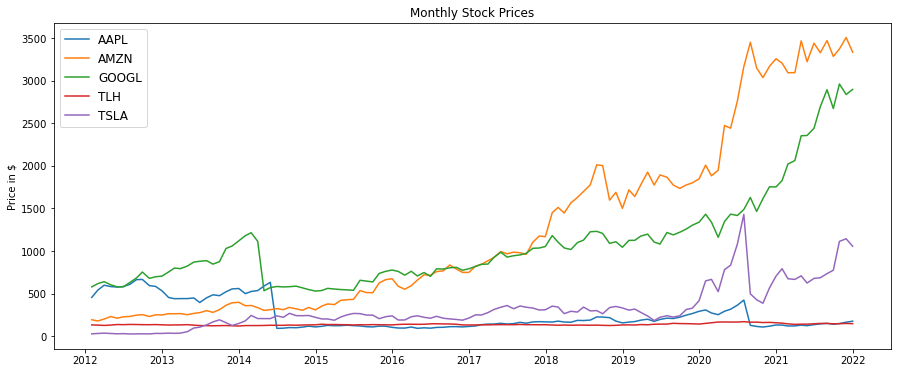

In [290]:
# plot monthly stock prices
df_price = df.pivot(columns='TICKER', values='PRC')
display(df_price)

plt.figure(figsize=(15, 6))
plt.plot(df_price, label=df_price.columns)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')
plt.title("Monthly Stock Prices")
plt.show()

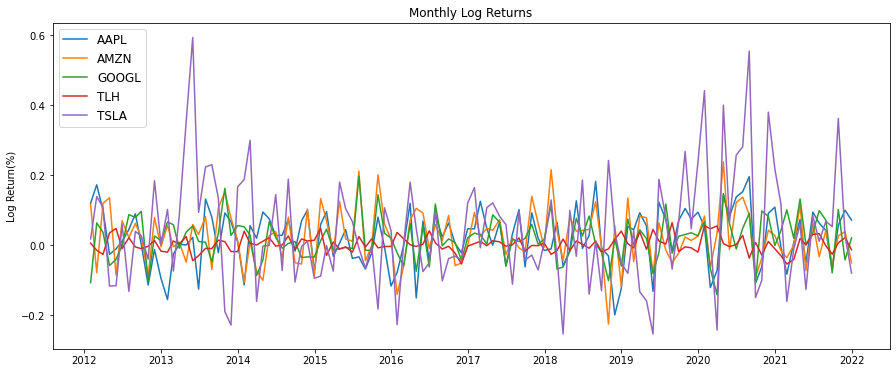

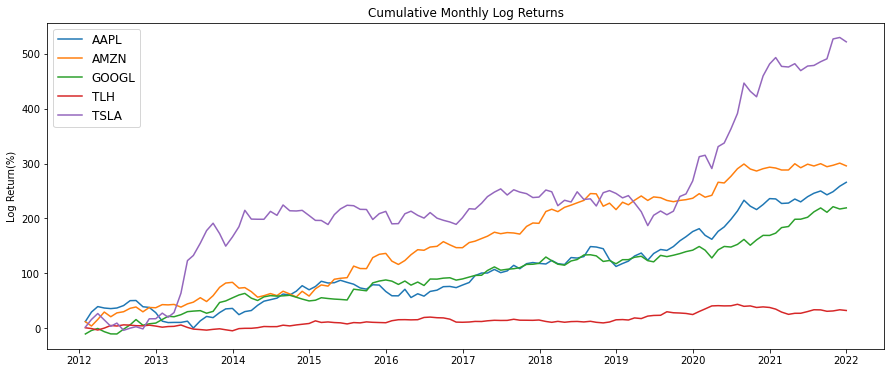

In [291]:
# calculate and plot monthly log returns
df['log_ret'] = np.log(1 + df['RET'])
df_ret = df.pivot(columns='TICKER', values='log_ret')

plt.figure(figsize=(15, 6))
plt.plot(df_ret, label=df_ret.columns)
plt.legend(loc='upper left', fontsize=12)
plt.title('Monthly Log Returns')
plt.ylabel('Log Return(%)')
plt.show()

# plot the cumulative sum of monthly log returns
plt.figure(figsize=(15, 6))
plt.plot(100 * np.cumsum(df_ret, axis=0), label=df_ret.columns)
plt.legend(loc='upper left', fontsize=12)
plt.title('Cumulative Monthly Log Returns')
plt.ylabel('Log Return(%)')
plt.show()

In [292]:
# display summary statistics of monthly log returns
df_stat = df.groupby('TICKER')['log_ret'].agg(['mean', 'std'])
print("Display summary statistics of monthly log returns(%)")
display(100 * df_stat)

Display summary statistics of monthly log returns(%)


,mean,std
TICKER,,
AAPL,2.215708,7.913518
AMZN,2.465135,7.800940
GOOGL,1.826994,6.140643
TLH,0.267255,2.256216
TSLA,4.350341,15.987220


Display the covariance matrix of each company


TICKER,AAPL,AMZN,GOOGL,TLH,TSLA
TICKER,,,,,
AAPL,0.006262,0.002518,0.001689,-0.000096,0.004191
AMZN,0.002518,0.006085,0.002356,-0.000061,0.002601
GOOGL,0.001689,0.002356,0.003771,-0.000218,0.002472
TLH,-0.000096,-0.000061,-0.000218,0.000509,-0.000566
TSLA,0.004191,0.002601,0.002472,-0.000566,0.025559


<AxesSubplot:xlabel='TICKER', ylabel='TICKER'>

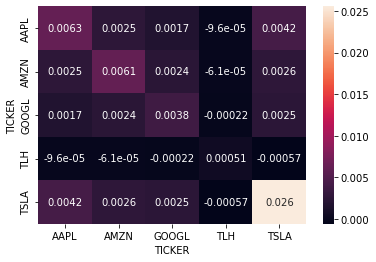

In [293]:
# display covariance matrix
print("Display the covariance matrix of each company")
cov_matrix_ret = df_ret.cov()
display(cov_matrix_ret)
sns.heatmap(cov_matrix_ret, annot=True)

Conclusion:

From the analysis of stock prices and cumulative returns, we can see that our 5 stocks are aligned with our expectations. 4 technologies stocks have higher return rates than the treasury bond, especially TESLA, which hit a sky-rocket increase in terms of stock prices and returns after 2013, overperforming the other 4 stocks most of time.

But high return rates are usually associated with higher volatilities and higher risks. Since our investment goal is to leverage risks and returns and maintain a balance between stability and potential for higher returns, instead of fully holding the stock with the highest return, we need to decide the allocation for investing in a mix of low-risk and high-risk assets.


### Find the optimal portfolio

The Sharpe ratio is a measure of risk-adjusted return. It describes how much excess return you receive for the volatility of holding a riskier asset. In the third part, we obtained one of our desired optimal portfolio (i.e the tangency portfolio) by calculating the maximum sharpe ratio under linear weight constraints. We get the risk-free rate at 1.52% from the 10-year treasury rate at 12/31/2021.

Furthermove, we implemented a Markowitz's portfolio optimization model and calculated the efficient frontier. This model aims to create the most return-to-risk efficient portfolio by analyzing various portfolio combinations based on expected returns (mean) and standard deviations (variance) of the assets.


In [294]:
from scipy.optimize import minimize, Bounds
import math

In [295]:
mean_returns = df_stat['mean']
cov_matrix = cov_matrix_ret
risk_free_rate = 0.0152  # 10-year treasury rate at 12/31/2021

In [296]:
def annualised_stat(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 12
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)
    return std, returns


def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = annualised_stat(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var


def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = Bounds(0, 1)
    opt_weights = sco.minimize(neg_sharpe_ratio,
                               num_assets * [
                                   1. / num_assets,
                               ],
                               args=(mean_returns, cov_matrix, risk_free_rate),
                               method='SLSQP',
                               bounds=bounds,
                               constraints=constraints)
    return opt_weights['x']

In [297]:
# calculate the optimal portfolio by max sharpe ratio
max_sharpe_weights = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
df_max_sharpe = pd.DataFrame(max_sharpe_weights,
                             columns=['weight'],
                             index=mean_returns.index)
df_max_sharpe

,weight
TICKER,
AAPL,0.101414
AMZN,0.166668
GOOGL,0.186161
TLH,0.451085
TSLA,0.094671


<AxesSubplot:ylabel='weight'>

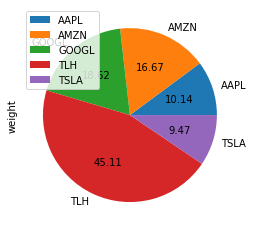

In [298]:
# barplot of the optimal portfolio by max sharpe ratio
df_max_sharpe.plot.pie(y='weight', autopct='%.2f')


In [299]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return annualised_stat(weights, mean_returns, cov_matrix)[0]


def min_volatility(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = Bounds(0, 1)

    opt_weights = sco.minimize(portfolio_volatility,
                               num_assets * [
                                   1. / num_assets,
                               ],
                               args=(mean_returns, cov_matrix),
                               method='SLSQP',
                               bounds=bounds,
                               constraints=constraints)

    return opt_weights['x']

In [300]:
# calculate the portfolio by min volatility
min_volatility_weights = min_volatility(mean_returns, cov_matrix)
df_min_volatility = pd.DataFrame(min_volatility_weights,
                                 columns=['weight'],
                                 index=mean_returns.index)
df_min_volatility

,weight
TICKER,
AAPL,0.027438
AMZN,0.004552
GOOGL,0.123912
TLH,0.827752
TSLA,0.016347


<AxesSubplot:ylabel='weight'>

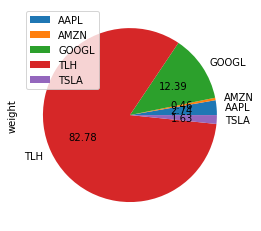

In [301]:
# barplot of the portfolio by min volatility
df_min_volatility.plot.pie(y='weight', autopct='%.2f')


In [302]:
# calculate the efficient frontier
def efficient_return(mean_returns, cov_matrix, target):

    def portfolio_return(weights):
        return annualised_stat(weights, mean_returns, cov_matrix)[1]

    num_assets = len(mean_returns)
    constraints = ({
        'type': 'eq',
        'fun': lambda x: portfolio_return(x) - target
    }, {
        'type': 'eq',
        'fun': lambda x: np.sum(x) - 1
    })
    bounds = Bounds(0, 1)
    result = sco.minimize(portfolio_volatility,
                          num_assets * [
                              1. / num_assets,
                          ],
                          args=(mean_returns, cov_matrix),
                          method='SLSQP',
                          bounds=bounds,
                          constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for target in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, target))
    return efficients

In [303]:
vol_max_sharpe, returns_max_sharpe = annualised_stat(max_sharpe_weights,
                                                     mean_returns, cov_matrix)
vol_min_vol, returns_min_vol = annualised_stat(min_volatility_weights,
                                               mean_returns, cov_matrix)

an_rt = mean_returns * 12
an_vol = df_stat['std'] * np.sqrt(12)

num_ports = 1000  # run 1000 portfolios
target = np.linspace(returns_min_vol, np.max(an_rt), num_ports)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

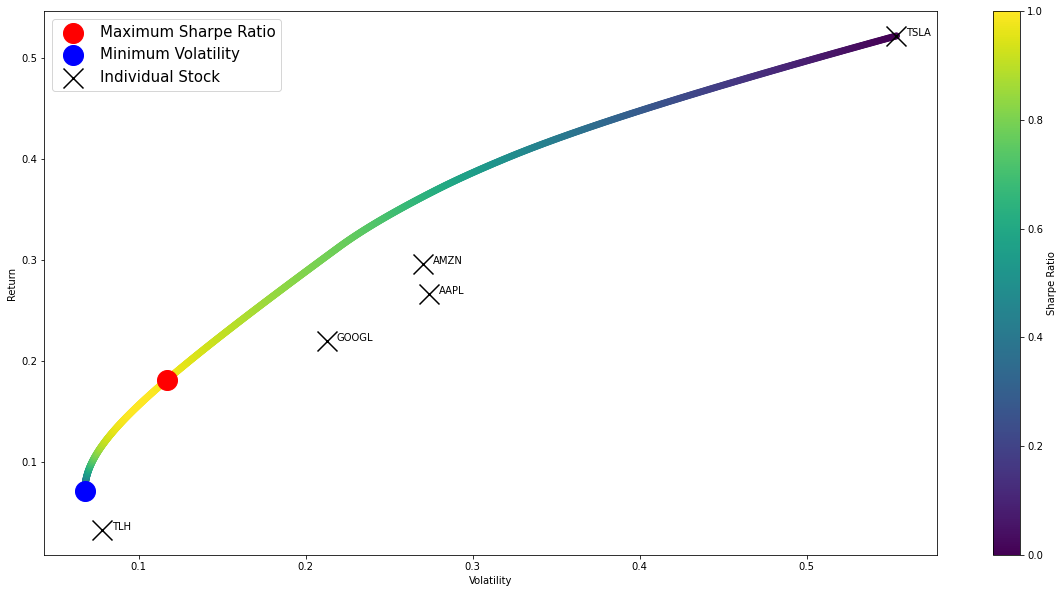

In [304]:
# plot the efficient frontier
plt.figure(figsize=(20, 10))
x = [p['fun'] for p in efficient_portfolios]
plt.scatter(x, target, c=target / x, cmap='viridis')
plt.scatter(vol_max_sharpe,
            returns_max_sharpe,
            marker='o',
            color='r',
            s=400,
            label='Maximum Sharpe Ratio')
plt.scatter(vol_min_vol,
            returns_min_vol,
            marker='o',
            color='b',
            s=400,
            label='Minimum Volatility')
plt.scatter(an_vol,
            an_rt,
            marker='x',
            color='black',
            s=400,
            label='Individual Stock')
for i, text in enumerate(an_rt.index):
    plt.annotate(text, (an_vol[i], an_rt[i]),
                 xytext=(10, 0),
                 textcoords='offset points')
plt.colorbar(label='Sharpe Ratio')
plt.legend(loc='upper left', fontsize=15)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [305]:
# summary
print("Maximum Sharpe Ratio Portfolio")
print("Annual Return:", round(returns_max_sharpe, 2), "\t",
      "Annual Volatility:", round(vol_max_sharpe, 2))
print("Allocation:", np.round((max_sharpe_weights * 100), 2))
print("Minimum Volatility Portfolio")
print("Annual Return:", round(returns_min_vol, 2), "\t", "Annual Volatility:",
      round(vol_min_vol, 2))
print("Allocation:", np.round((min_volatility_weights * 100), 2))
print("Holding Individual Stock:")
for i, text in enumerate(an_rt.index):
    print(text)
    print("Annual Return:", round(an_rt[i], 2), "\t", "Annual Volatility:",
          round(an_vol[i], 2))


Maximum Sharpe Ratio Portfolio
Annual Return: 0.18 	 Annual Volatility: 0.12
Allocation: [10.14 16.67 18.62 45.11  9.47]
Minimum Volatility Portfolio
Annual Return: 0.07 	 Annual Volatility: 0.07
Allocation: [ 2.74  0.46 12.39 82.78  1.63]
Holding Individual Stock:
AAPL
Annual Return: 0.27 	 Annual Volatility: 0.27
AMZN
Annual Return: 0.3 	 Annual Volatility: 0.27
GOOGL
Annual Return: 0.22 	 Annual Volatility: 0.21
TLH
Annual Return: 0.03 	 Annual Volatility: 0.08
TSLA
Annual Return: 0.52 	 Annual Volatility: 0.55


### Back Test


In this part, we basktested our strategy by comparing the performance of raw data and a risk-adjusted measure based on historical information.

In the last part, we generated a portfolio by measuring the max sharpe ratio. Assume we are investors now and we have the performance data of our assets in the past two year. We made our strategy based on the max sharpe ratio and we'd like to see how it perform in the next two year.

Thus, we generated the allocations of our portfolio by the data in every two year from 2012-2020, and implement it to test the data in the following two year. For example, we used data in 2012-2013 as known infomation and test our portfolio on the data in 2014-2015. We then accessed the risk free rate data from Fama French library. After that, we calculated the annual log return, annual volocity and sharpe ratio based on the data in the next year to evaluate if our strategy really works.


In [306]:
risk_free_rate = pdr.DataReader('F-F_Research_Data_Factors',
                                'famafrench',
                                start='2012-01',
                                end='2021-12')[0]['RF']
display(risk_free_rate)

Date
2012-01    0.00
2012-02    0.00
2012-03    0.00
2012-04    0.00
2012-05    0.01
           ... 
2021-08    0.00
2021-09    0.00
2021-10    0.00
2021-11    0.00
2021-12    0.01
Freq: M, Name: RF, Length: 120, dtype: float64

In [319]:
def generate_portfolio(df, year):
    hist_data = df[np.logical_or(df.index.year == year,
                                 df.index.year == year + 1)]
    mean_rfr = risk_free_rate[np.logical_or(
        risk_free_rate.index.year == year,
        risk_free_rate.index.year == year + 1)].mean()
    hist_mean = hist_data.groupby('TICKER')['log_ret'].agg('mean')
    df_ret = df.pivot(columns='TICKER', values='log_ret')
    df_hist_ret = hist_data.pivot(columns='TICKER', values='log_ret')
    hist_cov = df_hist_ret.cov()

    max_sharpe_weights = max_sharpe_ratio(hist_mean, hist_cov, mean_rfr)

    return max_sharpe_weights

In [320]:
def test_portfolio(max_sharpe_weights, df, year):
    test_data = df[np.logical_or(df.index.year == year,
                                 df.index.year == year + 1)]
    mean_rfr = risk_free_rate[np.logical_or(
        risk_free_rate.index.year == year,
        risk_free_rate.index.year == year + 1)].mean()
    test_mean = test_data.groupby('TICKER')['log_ret'].agg('mean')
    df_test_ret = test_data.pivot(columns='TICKER', values='log_ret')
    test_cov = df_test_ret.cov()

    vol_max_sharpe, returns_max_sharpe = annualised_stat(
        max_sharpe_weights, test_mean, test_cov)
    sharpe_ratio = -neg_sharpe_ratio(max_sharpe_weights, test_mean, test_cov,
                                     mean_rfr)

    return returns_max_sharpe, vol_max_sharpe, sharpe_ratio

In [325]:
def create_report():
    info_years = []
    test_years = []
    annual_return = []
    annual_volatility = []
    annual_sharpe_ratio = []

    for year in range(2012, 2020):
        returns_max_sharpe, vol_max_sharpe, sharpe_ratio = test_portfolio(
            generate_portfolio(df, year), df, year + 2)
        info_years.append(str(year) + '-' + str(year + 1))
        test_years.append(str(year + 2) + '-' + str(year + 3))
        annual_return.append(str(round(returns_max_sharpe * 100, 2)) + "%")
        annual_volatility.append(round(vol_max_sharpe, 2))
        annual_sharpe_ratio.append(round(sharpe_ratio, 2))

    df_summary = pd.DataFrame(list(
        zip(info_years, test_years, annual_return, annual_volatility,
            annual_sharpe_ratio)),
                              columns=[
                                  "Info Year", "Test Year", "Annual Return",
                                  "Annual Volatility", "Sharpe Ratio"
                              ])
    display(df_summary)

In [326]:
create_report()

,Info Year,Test Year,Annual Return,Annual Volocity,Sharpe Ratio
0,2012-2013,2014-2015,16.31%,0.13,1.24
1,2013-2014,2015-2016,7.27%,0.11,0.58
2,2014-2015,2016-2017,7.82%,0.07,0.52
3,2015-2016,2017-2018,34.73%,0.30,0.81
4,2016-2017,2018-2019,25.41%,0.26,0.35
5,2017-2018,2019-2020,53.73%,0.33,1.32
6,2018-2019,2020-2021,42.68%,0.30,1.37
7,2019-2020,2021-2022,8.31%,0.14,0.59


As shown in the summary table above, generally speaking, our portfolio got pretty decent results by having a positive annual return for each of the two-year pair. We also has a positive Shape Ratio and small annual volatility. Although the returns have relatively good years and relatively bad years, we should consider the influence brought by random market crisis. Overall, we believe our portfolio shows competitiveness in the back test for balancing the risk and returns and is a portfolio aligned with our investment goal.


### Monte-Carlo Simulation


In this part, we ran a Monte-Carlo simulation to simulate the portfolio's performance in the upcoming 6 month, calculated the possibility of losing 20% of the returns, to see if we can take the loss and stick with our strategy. We choose the max-sharpe ratio portfolio to represent our strategy.


In [312]:
N = 100_000  # simulation times
seed = 123
loss_threshold = 0.2
sim_months = 6

rng = np.random.default_rng(seed)
samples = rng.multivariate_normal(sim_months * mean_returns,
                                  sim_months * cov_matrix,
                                  size=N)
df_samples = pd.DataFrame(samples, columns=cov_matrix.columns)
display(100 * df_samples.agg(['mean', 'std']).transpose())

,mean,std
TICKER,,
AAPL,13.292065,19.359068
AMZN,14.803304,19.081174
GOOGL,10.953637,14.993237
TLH,1.628323,5.529935
TSLA,26.004808,39.212395


In [313]:
sim_returns = pd.DataFrame((max_sharpe_weights * df_samples).sum(axis=1),
                           columns=['sim_return'])
display(sim_returns)

,sim_return
0,0.099867
1,0.029150
2,-0.020235
3,0.153669
4,0.230461
...,...
99995,0.069748
99996,0.156663
99997,0.066517
99998,0.242906


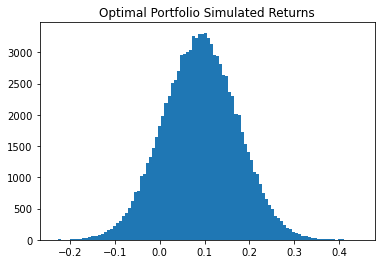

Probability that we lose more than 20.0% in 6 months: 0.01%


In [314]:
# Histogram
plt.figure()
plt.hist(sim_returns, bins=100)
plt.title('Optimal Portfolio Simulated Returns')
plt.show()

# How many times did our portfolio drop by 20% over 6 months?
is_lt_thresh = sim_returns < -loss_threshold  # whether simulated returns < -0.2
prob_hit_thresh = is_lt_thresh.mean()[0]
print(
    f'Probability that we lose more than {loss_threshold:.1%} in {sim_months} months: {prob_hit_thresh:.2%}'
)


Conclusion:

After running our simulation for 1000 times, we found that the probability that we lose more than 20.0% in 6 months is just 0.01%, which is a small probability event and shows the portfolio is fully acceptable considering the simulated future performance.


### Reference

1. https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
2. https://pub.towardsai.net/portfolio-optimization-using-python-f63e6281373c
3. https://www.kaggle.com/code/trangthvu/efficient-frontier-optimization/notebook
